In [2]:
import sys
sys.executable


'C:\\Users\\user\\miniconda3\\python.exe'

In [3]:
!pip install torchvision


In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor #ToTensor can take image data and turn it into a tensor(1D metrcis)


In [5]:
# MNIST is a popular dataset of handwritten digits commonly used for training various machine learning models
train_data=datasets.MNIST(
root='data',
train=True,
transform=ToTensor(), # converts the images in the dataset into PyTorch tensors
download=True #ensures that the dataset will be downloaded if it's not found in the specified root directory
)
test_data=datasets.MNIST(
root='data',
train=False,
transform=ToTensor(),
download=True
)

In [6]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [8]:
train_data.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [9]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [10]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [11]:
train_data.targets.size()

torch.Size([60000])

In [12]:
train_data.targets
# The labels in the MNIST dataset are integers ranging from 0 to 9 representing one of the 10 possible digits

tensor([5, 0, 4,  ..., 5, 6, 8])

In [13]:
# DaraLoader is used to load data from a dataset and provides features like batching, shuffling, and parallel data loading
from torch.utils.data import DataLoader
loaders={
    'train':DataLoader(train_data,
                      batch_size=100,  # how many samples will be included in each batch during training
                      shuffle=True, # Shuffling the dataset means randomizing the order of the samples
                      num_workers=1), # means that only one worker process will be used and increasing this number can speed up data loading, especially if you're loading data from disk
    'test':DataLoader(test_data,
                      batch_size=100,
                      shuffle=True,
                      num_workers=1),
}

In [18]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1f372f0b050>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1f372e99610>}

In [34]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # provides implementations of various optimization algorithms like SGD, Adam...

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # first convolutional layer with 1 input channel, 10 output channels (filters), and a kernel size of 5x5.
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d() # to prevent overfitting
        self.fc1 = nn.Linear(320, 50) #  First fully connected layer with 320 input features and 50 output features
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x, dim=1)




In [35]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(f"Train Epoch:{epoch} [{batch_idx * len(data)} / {len(loaders['train'].dataset)} {100. * batch_idx / len(loaders['train']):.0f}%] / {loss.item():.6f}")

def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(loaders['test'].dataset)
    print(f"\nTest set: Average loss:{test_loss:.4f}, Accuracy{correct}/{len(loaders['test'].dataset)} ({100.* correct / len(loaders['test'].dataset):.0f}%)\n")




In [36]:
for epoch in range(1,11):
    train(epoch)
    test()

Train Epoch:1 [0 / 60000 0%] / 2.301986
Train Epoch:1 [2000 / 60000 3%] / 2.284401
Train Epoch:1 [4000 / 60000 7%] / 2.141195
Train Epoch:1 [6000 / 60000 10%] / 1.900820
Train Epoch:1 [8000 / 60000 13%] / 1.914478
Train Epoch:1 [10000 / 60000 17%] / 1.878618
Train Epoch:1 [12000 / 60000 20%] / 1.794111
Train Epoch:1 [14000 / 60000 23%] / 1.754899
Train Epoch:1 [16000 / 60000 27%] / 1.713044
Train Epoch:1 [18000 / 60000 30%] / 1.761457
Train Epoch:1 [20000 / 60000 33%] / 1.709804
Train Epoch:1 [22000 / 60000 37%] / 1.748687
Train Epoch:1 [24000 / 60000 40%] / 1.648278
Train Epoch:1 [26000 / 60000 43%] / 1.682053
Train Epoch:1 [28000 / 60000 47%] / 1.652982
Train Epoch:1 [30000 / 60000 50%] / 1.663390
Train Epoch:1 [32000 / 60000 53%] / 1.608290
Train Epoch:1 [34000 / 60000 57%] / 1.641682
Train Epoch:1 [36000 / 60000 60%] / 1.646838
Train Epoch:1 [38000 / 60000 63%] / 1.611633
Train Epoch:1 [40000 / 60000 67%] / 1.636140
Train Epoch:1 [42000 / 60000 70%] / 1.613381
Train Epoch:1 [44000 

In [37]:
device

device(type='cpu')

Prediction:5


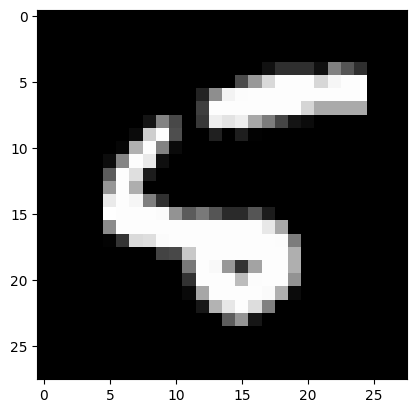

In [53]:
import matplotlib.pyplot as plt
model.eval()
data,target=test_data[8]
data=data.unsqueeze(0).to(device)
output=model(data)
prediction=output.argmax(dim=1,keepdim=True).item()
print(f'Prediction:{prediction}')
image=data.squeeze(0).cpu().numpy()
plt.imshow(image[0], cmap='gray')  # Reshape image to 2D array and display
plt.show()